In [ ]:
from google.colab import drive, files

drive.mount('/content/gdrive')

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
%load_ext tensorboard
import tensorboard
from datetime import datetime
from sklearn.feature_selection import *
from sklearn import preprocessing
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import math
import statistics

In [ ]:
dataset_url = '/content/gdrive/My Drive/colab/processed-mental-states (1).csv'
data = pd.read_csv(dataset_url)
data

,fw_mean_0,fw_mean_1,fw_mean_2,fw_mean_3,fw_stddev_0,fw_stddev_1,fw_stddev_2,fw_stddev_3,fw_min_0,fw_min_1,fw_min_2,fw_min_3,fw_max_0,fw_max_1,fw_max_2,fw_max_3,fw_skew_0,fw_skew_1,fw_skew_2,fw_skew_3,fw_kurt_0,fw_kurt_1,fw_kurt_2,fw_kurt_3,variance_0,variance_1,variance_2,variance_3,covar_0,covar_1,covar_2,covar_3,covar_4,covar_5,eignval_0,eignval_1,eignval_2,eignval_3,hw_d_mean_0,hw_d_mean_1,...,fft_max_1,fft_max_2,fft_max_3,fft_max_4,fft_max_5,fft_max_6,fft_max_7,fft_max_8,fft_max_9,fft_max_10,fft_max_11,fft_max_12,fft_max_13,fft_max_14,fft_max_15,fft_max_16,fft_max_17,fft_max_18,fft_max_19,fft_max_20,fft_max_21,fft_max_22,fft_max_23,fft_max_24,fft_max_25,fft_max_26,fft_max_27,fft_max_28,fft_max_29,fft_max_30,fft_max_31,fft_max_32,fft_max_33,fft_max_34,fft_max_35,fft_max_36,fft_max_37,fft_max_38,fft_max_39,class
0,32.550793,33.992805,41.450504,31.250000,16.797984,6.889376,35.644249,23.428011,-7.324,14.648,-56.641,-32.715,73.730,51.758,108.887,104.492,-0.109151,-0.080369,-0.796775,0.135306,-0.652712,0.003292,0.029437,-0.247387,282.172255,47.463503,1270.512520,548.871687,22.412174,152.682063,300.092982,8.332133,9.829008,53.157299,1307.667548,715.774780,83.363447,42.214191,1.808180,0.915547,...,457.873489,303.908530,506.965685,323.717322,304.590766,314.133048,323.093775,317.578070,2065.717608,194.964665,215.903424,241.148854,250.330628,192.439095,283.373904,171.188446,184.512547,180.983304,196.737194,4375.519253,3576.294345,1175.956666,672.861443,370.194455,372.584048,344.465305,280.724950,251.539994,1045.266117,431.972582,336.890574,900.821620,426.376850,427.396831,356.039063,275.420504,289.891867,531.370634,3021.742323,1.0
1,24.456074,38.948059,50.006879,23.902922,23.773204,7.344168,5.519740,24.511721,-20.020,18.066,35.156,-25.391,75.684,56.152,68.359,76.660,-0.190502,-0.303926,0.495477,-0.108786,-1.169958,-0.245737,0.483999,-1.167592,565.165215,53.936797,30.467531,600.824481,-25.039650,-22.046247,550.499855,-9.878105,-32.736830,-10.052231,1135.777652,59.034113,34.329553,21.252705,-2.212539,2.014180,...,259.916848,265.114588,298.862988,379.267778,339.461370,266.644021,356.632545,258.854018,3576.919057,607.103191,412.406163,457.571715,394.910414,272.359164,201.344996,187.907419,169.940677,161.621699,229.306538,336.190547,186.347092,452.188419,207.860381,190.022173,210.654123,172.694361,125.136777,191.795169,187.768190,302.412245,383.265311,362.958872,257.160503,265.827569,331.501311,310.676616,318.837338,315.457793,3739.887509,2.0
2,25.657656,35.291672,25.625223,25.922789,24.906624,6.074741,8.567686,22.099088,-55.664,17.090,-7.324,-58.594,90.820,51.270,42.969,75.195,-0.080041,-0.146692,-0.825808,-0.590300,-0.078170,-0.206837,1.314753,0.953482,620.339928,36.902473,73.405239,488.369676,37.616642,-48.415907,398.078387,-26.054128,-3.545992,17.472853,959.411710,179.671825,56.902068,23.031711,14.762891,0.042031,...,819.195415,723.747166,1099.132493,622.025704,400.247312,431.871178,427.407929,387.688063,2667.969404,334.984255,257.907659,379.865911,239.764432,166.459034,281.620770,268.602051,183.902825,160.271476,193.102678,383.572737,485.923972,477.681117,498.799810,606.514528,354.540278,212.400459,238.342640,207.796713,199.257379,679.301751,932.213052,449.645018,840.763429,587.443275,447.624919,540.204834,469.241980,461.096575,2244.295410,0.0
3,30.174219,33.203078,55.303609,19.472137,45.510590,7.032357,14.151138,218.010042,-52.246,14.160,36.133,-308.594,115.723,54.688,97.168,342.285,0.002974,0.180973,1.522778,-0.006417,-1.409940,-0.237772,1.105142,-1.487159,2071.213773,49.454043,200.254716,47528.378305,-204.530864,65.928238,9605.844438,0.065215,-1113.852107,290.043665,49502.617227,19.274433,127.833589,199.575589,2.403297,2.075219,...,311.551870,299.005365,401.961856,415.452180,468.477295,539.532850,471.486124,617.780658,7147.362474,368.426819,321.709432,224.265618,164.951824,208.835381,184.579025,130.706503,166.548339,157.260256,815.002069,1571.617940,1275.595740,960.191408,534.353463,140.627372,180.346104,154.369786,132.939846,153

In [ ]:
# Split columns as features and class
#X = data.iloc[:,14:-1] # features
X = data.iloc[:,0:-1] # features
Y = data.iloc[:,-1] # target class
img_size = tf.constant([20,20])

In [ ]:
def SelectFeaturesChi2(X,Y,img_size):
    # Modify X to be >= 0
    # Add global min for every data entry
    global_min = X.min().min()
    X = pd.DataFrame([X[col] + abs(global_min) for col in X.columns]).T

    # Try with row min instead of global min
    #row_min = X.min(axis=1)
    #X = pd.DataFrame([X.iloc[i] + abs(row_min[i]) for i in X.index])
    #print(X.head())

    # Select best feature using chi2 algorithm
    num_features = img_size.numpy()[0]*img_size.numpy()[1]

    bestFeatures = SelectKBest(score_func=chi2,k=num_features)
    fit = bestFeatures.fit(X,Y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Features', 'Score']

    # Select the top 400 (20 x 20 image matrix dimensions) features, Score >= 10
    top_features = pd.DataFrame(featureScores.nlargest(num_features,'Score')).sort_index()
    # top_features = pd.DataFrame(featureScores.nlargest(num_features,'Score'))
    X = X.filter(top_features.Features,axis=1)

    # Substract global min again to the data, to restore it after feature selection
    X = pd.DataFrame([X[col] - abs(global_min) for col in X.columns]).T
    
    # Try with row min instead of global min
    #X = pd.DataFrame([X.iloc[i] - abs(row_min[i] for i in X.index])

    return X

def SelectFeaturesMutualInfo(X,Y,img_size):
    # Modify X to be >= 0
    # Add global min for every data entry
    #global_min = X.min().min()
    #X = pd.DataFrame([X[col] + abs(global_min) for col in X.columns]).T

    # Select best feature using mutual_info_classif algorithm
    num_features = img_size.numpy()[0]*img_size.numpy()[1]

    bestFeatures = SelectKBest(score_func=mutual_info_classif,k=num_features)
    fit = bestFeatures.fit(X,Y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Features', 'Score']

    # Select the top features, Score >= 10
    top_features = pd.DataFrame(featureScores.nlargest(num_features,'Score')).sort_index()
    X = X.filter(top_features.Features,axis=1)

    # Substract global min again to the data, to restore it after feature selection
    #X = pd.DataFrame([X[col] - abs(global_min) for col in X.columns]).T
    return X

X = SelectFeaturesChi2(X,Y,img_size)

In [ ]:
# Normalize X so we can use the data as a grayscale image
X_norm = X.values
# I should try multiple methods of normalization to see if they matter on training
# 1. MaxAbsScaler
# 2. MinMaxScaler
# scaler = MaxAbsScaler(copy=False)
# scaler = MinMaxScaler(copy=False)
# X_norm = scaler.fit_transform(X_norm)

# X_norm = preprocessing.scale(X_norm, axis=1)
# X_norm = preprocessing.robust_scale(X_norm, axis=0)
X_norm = preprocessing.minmax_scale(X_norm, axis=1)

X = pd.DataFrame(X_norm,columns=X.columns)
print(X)

      fw_mean_0  fw_mean_1  fw_mean_2  ...  fft_max_37  fft_max_38  fft_max_39
0      0.028154   0.028476   0.030145  ...    0.085740    0.139777    0.697059
1      0.015160   0.019001   0.021933  ...    0.093191    0.092295    1.000000
2      0.030900   0.034434   0.030888  ...    0.193590    0.190603    0.844612
3      0.022602   0.022662   0.023098  ...    0.069498    0.079290    0.710260
4      0.057094   0.070735   0.068991  ...    0.383744    0.443670    0.412005
...         ...        ...        ...  ...         ...         ...         ...
8563   0.024448   0.025073   0.026012  ...    0.096857    0.112807    0.932319
8564   0.012343   0.013016   0.014576  ...    0.107894    0.125532    1.000000
8565   0.046806   0.041342   0.049517  ...    0.212909    0.167931    0.566140
8566   0.002971   0.002980   0.002010  ...    0.007661    0.008250    0.083501
8567   0.058668   0.063807   0.062262  ...    0.166550    0.170007    1.000000

[8568 rows x 400 columns]


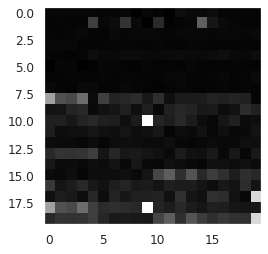

In [ ]:
plt.imshow(X.iloc[2,:].values.reshape(20,20), cmap='gray')
plt.grid(False)
plt.show()

In [ ]:
# One Hot Encod labels for use in CCE
Y = keras.utils.to_categorical(Y.values,num_classes=3)

# Split dataset into train and test (70% train and 30% test)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,train_size=0.9)
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train,train_size=0.8)

X_train = tf.reshape(X_train.values,[-1,img_size.numpy()[0],img_size.numpy()[1],1])
X_test = tf.reshape(X_test.values,[-1,img_size.numpy()[0],img_size.numpy()[1],1])
X_val = tf.reshape(X_val.values,[-1,img_size.numpy()[0],img_size.numpy()[1],1])

Y_train = Y_train
Y_test = Y_test
Y_val = Y_val
print("Train len: {}\nTest len: {}\nVal len: {}".format(Y_train.shape, Y_test.shape, Y_val.shape))

Train len: (6168, 3)
Test len: (857, 3)
Val len: (1543, 3)


In [ ]:
def MindStateNetGood(img_size):
    # Using this model I got the following results on a 20x20x1 image
    # model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0007,amsgrad=True), loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
    # patience_epoch = 10
    # early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience_epoch,verbose=1,restore_best_weights=True)
    # reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.00001,patience=5, factor=0.1)
    # history = model.fit(X_train, Y_train, 32, 100, validation_data=(X_val,Y_val),callbacks=[reduce_lr])

    # loss: 0.2249 - accuracy: 0.9593 - val_loss: 0.3767 - val_accuracy: 0.9054 - lr: 1.0000e-05
    # Test loss: 0.32166269421577454
    # Test accuracy: 0.9334889054298401

    inputs = keras.Input(shape=(img_size.numpy()[0],img_size.numpy()[1],1))

    x = keras.layers.Conv2D(32,(2,2),padding='same',strides=1,activation='relu')(inputs)
    x = keras.layers.Conv2D(32,(2,2),padding='valid',strides=1,activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Conv2D(64,(2,2),padding='same',strides=2,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = keras.layers.Conv2D(64,(2,2),padding='valid',strides=1,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Conv2D(128,(2,2),padding='same',strides=2,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.05))(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Conv2D(256,(2,2),padding='valid',strides=1,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256,activation='relu')(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(3,activation='softmax')(x)

    return keras.Model(inputs, x)

In [ ]:
def compute_model(model, loop_cnt):
    i = 0
    avg_acc = 0
    avg_loss = 0
    history = 0

    acc = []
    loss = []

    fit_verbose = 1 if loop_cnt == 1 else 2

    tf.random.set_seed(1)
    model_ = model
    Wsave = model_.get_weights()

    for i in range(loop_cnt):
        print(f"Starting run number {i+1}\n")
        model_.set_weights(Wsave)
        model_.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0007,amsgrad=True), loss=keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
        logdir = '/content/gdrive/My Drive/colab/logs/fit/' + datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboad_cb = keras.callbacks.TensorBoard(log_dir=logdir)
        early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=10,verbose=1,restore_best_weights=True)
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss',min_lr=0.000007,patience=5, factor=0.07)
        history = model_.fit(X_train, Y_train, 32, 100, verbose=fit_verbose, validation_data=(X_val,Y_val),callbacks=[reduce_lr])

        # Test model on test dataset
        results = model_.evaluate(X_test, Y_test)
        loss.append(results[0])
        acc.append(results[1])
        avg_loss += results[0] / loop_cnt
        avg_acc += results[1] / loop_cnt
        
    for i in range(loop_cnt):
        print(f"Loss {i+1}: {loss[i]}\nAcc {i+1}: {acc[i]}\n")
    print(f"Avg loss: {avg_loss}\nAvg acc: {avg_acc}\n")
    predictions = model_.predict(X_test)
    return predictions, history, avg_loss, avg_acc

In [ ]:
model = MindStateNetGood(img_size)
model.summary()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
predictions, history, avg_loss, avg_acc = compute_model(model, 1)

Starting run number 1

Epoch 1/100
193/193 [==============================] - 1s 7ms/step - loss: 8.2394 - accuracy: 0.5443 - val_loss: 6.6271 - val_accuracy: 0.3182 - lr: 7.0000e-04
Epoch 2/100
193/193 [==============================] - 1s 6ms/step - loss: 4.1659 - accuracy: 0.6485 - val_loss: 4.3527 - val_accuracy: 0.3681 - lr: 7.0000e-04
Epoch 3/100
193/193 [==============================] - 1s 6ms/step - loss: 2.3125 - accuracy: 0.6767 - val_loss: 3.0146 - val_accuracy: 0.4809 - lr: 7.0000e-04
Epoch 4/100
193/193 [==============================] - 1s 6ms/step - loss: 1.5531 - accuracy: 0.7038 - val_loss: 1.5501 - val_accuracy: 0.5723 - lr: 7.0000e-04
Epoch 5/100
193/193 [==============================] - 1s 6ms/step - loss: 1.1655 - accuracy: 0.7284 - val_loss: 1.0274 - val_accuracy: 0.7712 - lr: 7.0000e-04
Epoch 6/100
193/193 [==============================] - 1s 6ms/step - loss: 0.9912 - accuracy: 0.7409 - val_loss: 1.0391 - val_accuracy: 0.6753 - lr: 7.0000e-04
Epoch 7/100
193/1

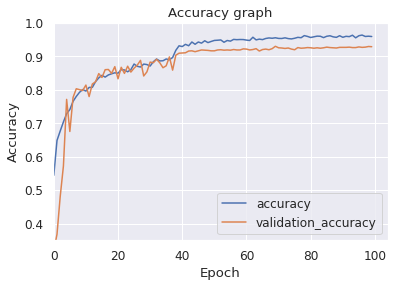

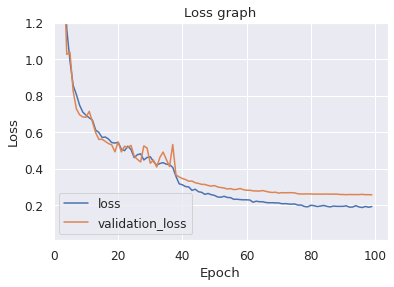

In [ ]:
# Evaluating the model through graphs
plt.title('Accuracy graph')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.35, 1])
plt.xlim(left=-0.3)
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
# plt.savefig("acc_graph.png", dpi=100, bbox_inches='tight')
# files.download("/content/acc_graph.png")

plt.figure()
plt.title('Loss graph')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.009, 1.2])
plt.xlim(left=-0.3)
plt.legend(loc='lower left')
plt.grid(True)
plt.show()
# plt.savefig("loss_graph.png", dpi=100, bbox_inches='tight')
# files.download("/content/loss_graph.png")

In [ ]:
true_class_pred = np.argmax(predictions,axis=1)
true_class = np.argmax(Y_test,axis=1)

In [ ]:
# Classification report
from sklearn.metrics import classification_report, matthews_corrcoef
target_names = ['neutru','concentrat','relaxat']
print(classification_report(true_class, true_class_pred, target_names=target_names))

              precision    recall  f1-score   support

      neutru       0.93      0.96      0.94       274
  concentrat       0.96      0.96      0.96       289
     relaxat       0.95      0.91      0.93       294

    accuracy                           0.94       857
   macro avg       0.94      0.94      0.94       857
weighted avg       0.94      0.94      0.94       857



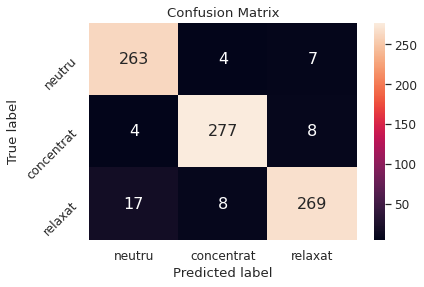

In [ ]:
import seaborn as sn
from sklearn import metrics
cm = metrics.confusion_matrix(true_class, true_class_pred)

sn.set(font_scale=1.1) # for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='g', xticklabels=target_names, yticklabels=target_names,cbar=True) # font size
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.yticks(rotation=45)
plt.show()
# plt.savefig("conf_matrix.png", dpi=100, bbox_inches='tight')
# files.download("/content/conf_matrix.png")